<h1>Etude du dimensionnement des trous dans un instrument à vent</h1>
&nbsp;
&nbsp;
&nbsp;
&nbsp;
<div><ul>
    <li><span><a href="#Modélisation"><span>1&nbsp;&nbsp;</span>Modélisation</a></span></li>
    <li><span><a href="#Equations"><span>2&nbsp;&nbsp;</span>Equations</a></span></li>
    <li><span><a href="#FEniCS"><span>3&nbsp;&nbsp;</span>FEniCS</a></span></li>
    <li><span><a href="#Paramètre-aléatoire-et-interprétations"><span>4&nbsp;&nbsp;</span>Paramètre aléatoire et interprétations</a></span></li>
    <li><span><a href="#Conclusion"><span>5&nbsp;&nbsp;</span>Conclusion</a></span></li>
    <li><span><a href="#Sources"><span>6&nbsp;&nbsp;</span>Sources</a></span></li>
</ul></div>

L'apparition des premiers instruments à vent remonte à l'âge préhistorique, mais le principe de fonctionnement est toujours le même : une source de vibrations, un tube, et des trous à boucher pour faire fluctuer le son et changer de note. Si les différents paramètres, comme la taille des trous, ont été déterminé par empirisme, il est aujourd'hui intéressant de comprendre la physique derrière pour améliorer les instruments, et en développer de nouveaux. La position des trous permet de modifier la note jouée, mais nous allons montrer que pour cela il faut qu'ils aient une dimension bien précise.


<a href="https://ibb.co/WKLzbLj"><img src="https://i.ibb.co/DKZMxZT/edp-basson.png" alt="edp-basson" border="0"></a>

# Modélisation

L'instrument est représenté par un tube, avec une ouverture d'un côté et un flux d'air entrant de l'autre (qui modélise le souffle du musicien). On considère un domaine de 8 par 20, le tube ayant une largeur de 1 et des parois d'une épaisseur de 0.5 : 

<a href="https://ibb.co/myFTN6G"><img src="https://i.ibb.co/Wzp5Vg6/sch-ma.png" alt="sch-ma" border="0"></a>

Hormis l'arrivée d'air dans le tube, les bords à gauche et à droite du domaine sont libres. La vitesse est fixée nulle aux bord inférieurs et supérieurs.

Le domaine sera ensuite modifié pour ajouter des trous sur la partie supérieur du domaine.

# Equations

La vitesse $\vec{u}$ et la pression de l'air $p$ au sein du tube sont régis par les équations de Navier-Stokes :

\begin{equation}
\begin{cases}
    \rho \left( \frac{\partial \vec{u}}{\partial t} + (\vec{u} . \nabla) \vec{u} \right) = -\nabla p + \rho \vec{g} + \mu \Delta \vec{u} \\
    \nabla . \vec{u} = 0
\end{cases}
\end{equation}

Nous nous plaçons en régime stationnaire, donc $ \frac{\partial \vec{u}}{\partial t} = 0 $

Pour un fluide tel que l'air, dans ces conditions le poids est négligeable face aux forces d'inertie.

En introduisant la viscosité cinématique $\nu$ et avec  $\rho \approx 1$, on obtient finalement :

\begin{equation}
\begin{cases}
    \nu \Delta \vec{u} + (\vec{u} . \nabla) \vec{u} + \nabla p = 0 \\
    \nabla . \vec{u} = 0
\end{cases}
\end{equation}


Soit T le tube représentant le conduit de l'instrument. On définit le domaine $\Omega = [0,20] \times [0,8] \setminus T$. Nous pouvons alors poser les conditions limites suivantes :

\begin{equation}
\\(CL)
\begin{cases}
    \vec{u} \rvert_{[0,20] \times 0} = 0 \qquad \mbox{ (bord inférieur du domaine) }\\
    \vec{u} \rvert_{[0,20] \times 8} = 0 \qquad \mbox{ (bord supérieur du domaine) }\\
    \vec{u} \rvert_{0 \times [0,8]} = \vec{u}_{in} \qquad \mbox{ (entrée d'air, bord droit du domaine) }\\
    \vec{u} \rvert_{\partial T} = 0 \qquad \mbox{ (sur la frontière du tube) }\\
\end{cases}
\end{equation}


Pour modéliser un instrument à vent, il faut que l'air arrive seulement dans le tube parallélement à celui-ci. Pour pouvoir assurer la convergence de résolution des équations, il est aussi nécessaire que cette entrée d'air converge vers 0 aux bords du tube. Ainsi, nous pouvons définir :

\begin{equation}
\\u_{in} = 
\begin{cases}
    u_{max}\frac{(y - 3.5)(4.5-y)}{8^2} \qquad \mbox{ si 3.5 $\leq$ y $\leq$ 4.5 (dans le tube) }\\
    0 \qquad \mbox{ sinon }\\
\end{cases}
\end{equation}
où $u_{max}$ est un paramètre à faire varier, il doit correspondre au souffle d'un homme pour notre cas de l'instrument à vent.

La formulation variationnelle de ces équations, telle que formulée dans la littérature, est alors :

\begin{equation}
    a((u,p),(v,q)) = \int_{\Omega} ( \nu \nabla u . \nabla v + (\nabla u . u ).v - p \nabla . v - q \nabla . u ) dx = 0
\end{equation}
pour tout $(v,q) \in W = V * Q$

# FEniCS

Utilisons FEniCS pour résoudre le problème posé :

In [1]:
from dolfin import *
import mshr
import matplotlib.pyplot as plt

Définition des paramètres :

In [2]:
u_max = 10
u_in = Expression(("U*(x[1]-3.5)*(4.5 - x[1])/(8*8)", "0.0"),degree=2, U=u_max)
nu = Constant(0.001)

#Paramètre de maille
N_maille = 64

Création du domaine, avec 2 trous :

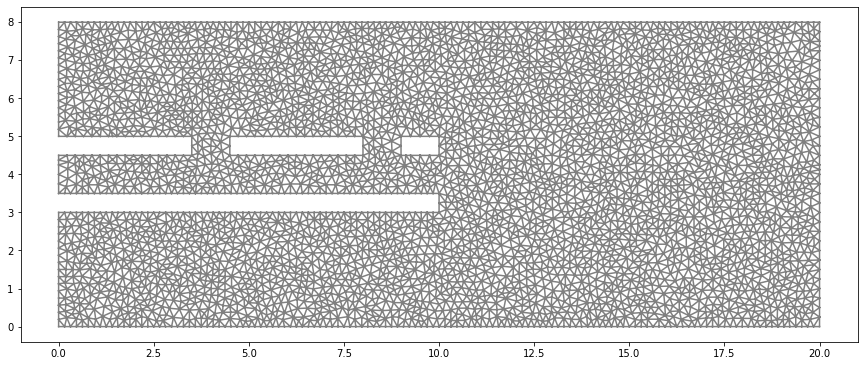

In [3]:
L = 20 
W = 8
geometry = mshr.Rectangle(Point(0.0, 0.0), Point(L, W)) \
            - mshr.Rectangle(Point(0,3.0), Point(10,3.5)) \
            - mshr.Rectangle(Point(0,4.5), Point(10,5)) \
            + mshr.Rectangle(Point(3.5,4.5), Point(4.5,5)) \
            + mshr.Rectangle(Point(8,4.5), Point(9,5))
    
mesh = mshr.generate_mesh(geometry, N_maille)
plt.figure(0, figsize = (15,15))
plot(mesh)

Ajout des conditions limites et construction de l'espace des fonctions :

In [4]:
bndry = MeshFunction("size_t", mesh, mesh.topology().dim()-1)
for f in facets(mesh):
    mp = f.midpoint()
    if  near(mp[0], 0.0) and 3.5<mp[1]<4.5:  # entrée d'air
        bndry[f] = 1
    elif near(mp[0], L):  # sortie
        bndry[f] = 2
    elif near(mp[1], 0.0) or near(mp[1], W):  # bords inférieurs et supérieurs du domaine
        bndry[f] = 3
    elif ((mp[0]<=10 and mp[0]>=0 and mp[1]<=3.5 and mp[1]>=3) or \
        (mp[0]<=10 and mp[0]>=0 and mp[1]<=5 and mp[1]>=4.5)) and not (3.5<mp[0]<4.5 and 4.5<mp[1]<5) \
        and not (8<mp[0]<9 and 4.5<mp[1]<5): # tube
        bndry[f] = 5

# Espaces des fonctions
P2 = VectorElement("P", mesh.ufl_cell(), 2)
P1 = FiniteElement("P", mesh.ufl_cell(), 1)
TH = MixedElement([P2, P1])
W = FunctionSpace(mesh, TH)

# Conditions de Dirichlet
bc_walls = DirichletBC(W.sub(0), (0, 0), bndry, 3)
bc_tube = DirichletBC(W.sub(0), (0, 0), bndry, 5)
bc_in = DirichletBC(W.sub(0), u_in, bndry, 1)
bcs = [bc_tube, bc_walls, bc_in]

Implémentation de la formulation variationnelle  :

In [5]:
v, q = TestFunctions(W)
w = Function(W)
u, p = split(w)
F = nu*inner(grad(u), grad(v))*dx + dot(dot(grad(u), u), v)*dx \
    - p*div(v)*dx - q*div(u)*dx

Résolution et affichage de la solution :

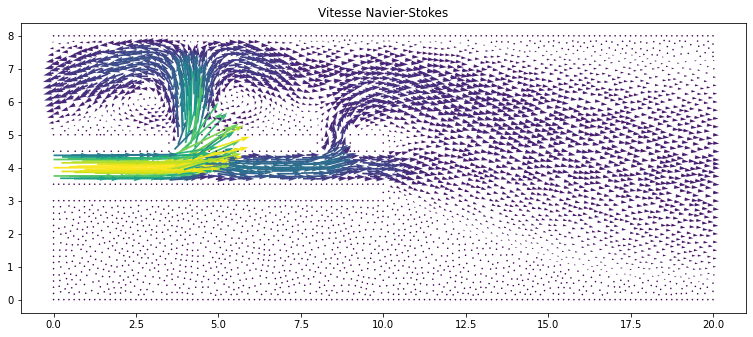

In [6]:
solve(F == 0, w, bcs)


plt.figure(2, figsize=(13,13))
u, p = w.split()
pl = plot(u, title='Vitesse Navier-Stokes')

L'affichage sous forme de vecteur n'est pas le plus lisible dans le cadre de ce problème. Voici un affichage de la norme de la vitesse, plus exploitable visuellement :

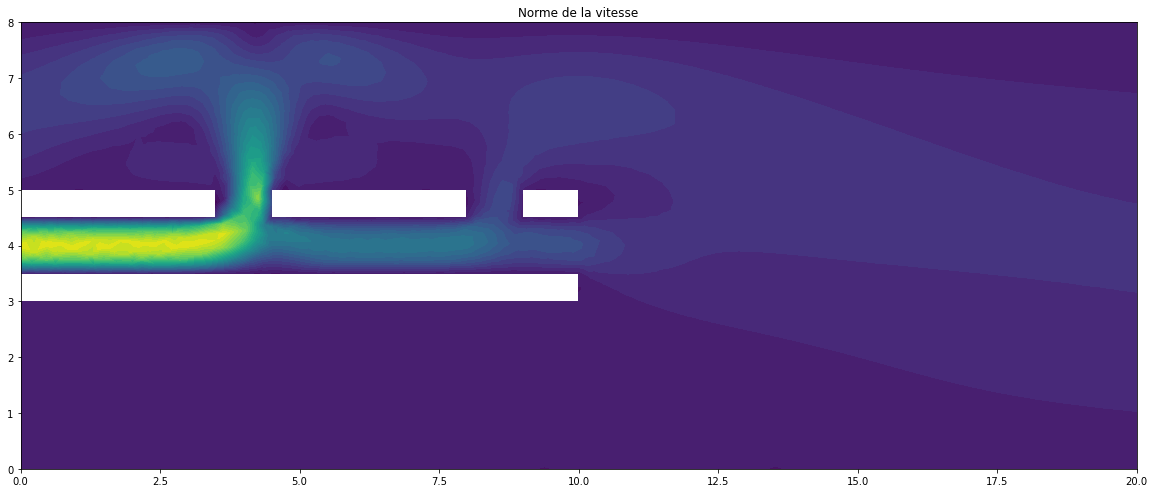

In [7]:
(ux, uy)= u.split(True)
plt.figure(figsize=(20,20))
plot(sqrt(ux**2+uy**2), title='Norme de la vitesse')

# Paramètre aléatoire et interprétations

Dans le résultat précédent, il apparait clairement que l'air sort en majorité par le premier trou, donc le second n'est pas très utile et ne modifie pas beaucoup le flux d'air... il perd donc tout son intérêt et la note jouée n'est pas celle souhaitée par le musicien !

Il est donc pertinent de regarder le résultat pour des trous plus faibles, de dimension 0.5 unité :

In [ ]:
geometry = mshr.Rectangle(Point(0.0, 0.0), Point(20, 8)) \
            - mshr.Rectangle(Point(0,3.0), Point(10,3.5)) \
            - mshr.Rectangle(Point(0,4.5), Point(10,5)) \
            + mshr.Rectangle(Point(3.5,4.5), Point(4,5)) \
            + mshr.Rectangle(Point(8,4.5), Point(8.5,5))
    
mesh = mshr.generate_mesh(geometry, N_maille)

bndry = MeshFunction("size_t", mesh, mesh.topology().dim()-1)
for f in facets(mesh):
    mp = f.midpoint()
    if  near(mp[0], 0.0) and 3.5<mp[1]<4.5:  # entrée d'air
        bndry[f] = 1
    elif near(mp[0], 20):  # outflow
        bndry[f] = 2
    elif near(mp[1], 0.0) or near(mp[1], 8):  # bords inférieurs et supérieurs du domaine
        bndry[f] = 3
    elif ((mp[0]<=10 and mp[0]>=0 and mp[1]<=3.5 and mp[1]>=3) or \
        (mp[0]<=10 and mp[0]>=0 and mp[1]<=5 and mp[1]>=4.5)) and not (3.5<mp[0]<4 and 4.5<mp[1]<5) \
        and not (8<mp[0]<8.5 and 4.5<mp[1]<5): # tube
        bndry[f] = 5

# Espaces des fonctions
P2 = VectorElement("P", mesh.ufl_cell(), 2)
P1 = FiniteElement("P", mesh.ufl_cell(), 1)
TH = MixedElement([P2, P1])
W = FunctionSpace(mesh, TH)

# Conditions de Dirichlet
bc_walls = DirichletBC(W.sub(0), (0, 0), bndry, 3)
bc_tube = DirichletBC(W.sub(0), (0, 0), bndry, 5)
bc_in = DirichletBC(W.sub(0), u_in, bndry, 1)
bcs = [bc_tube, bc_walls, bc_in]

v, q = TestFunctions(W)
w = Function(W)
u, p = split(w)
F = nu*inner(grad(u), grad(v))*dx + dot(dot(grad(u), u), v)*dx \
    - p*div(v)*dx - q*div(u)*dx

solve(F == 0, w, bcs)

u, p = w.split()
(ux, uy)= u.split(True)
plt.figure(figsize=(20,20))
plot(sqrt(ux**2+uy**2), title='Norme de la vitesse')

Ici, il apparait que l'air parvient jusqu'au second trou, mais n'en sort pas. Trouvons un juste milieu en n'agrandissant que le second trou:

In [ ]:
geometry = mshr.Rectangle(Point(0.0, 0.0), Point(20, 8)) \
            - mshr.Rectangle(Point(0,3.0), Point(10,3.5)) \
            - mshr.Rectangle(Point(0,4.5), Point(10,5)) \
            + mshr.Rectangle(Point(3.5,4.5), Point(4,5)) \
            + mshr.Rectangle(Point(8,4.5), Point(9,5))
    
mesh = mshr.generate_mesh(geometry, N_maille)

bndry = MeshFunction("size_t", mesh, mesh.topology().dim()-1)
for f in facets(mesh):
    mp = f.midpoint()
    if  near(mp[0], 0.0) and 3.5<mp[1]<4.5:  # entrée d'air
        bndry[f] = 1
    elif near(mp[0], 20):  # outflow
        bndry[f] = 2
    elif near(mp[1], 0.0) or near(mp[1], 8):  # bords inférieurs et supérieurs du domaine
        bndry[f] = 3
    elif ((mp[0]<=10 and mp[0]>=0 and mp[1]<=3.5 and mp[1]>=3) or \
        (mp[0]<=10 and mp[0]>=0 and mp[1]<=5 and mp[1]>=4.5)) and not (3.5<mp[0]<4 and 4.5<mp[1]<5) \
        and not (8<mp[0]<9 and 4.5<mp[1]<5): # tube
        bndry[f] = 5

# Espaces des fonctions
P2 = VectorElement("P", mesh.ufl_cell(), 2)
P1 = FiniteElement("P", mesh.ufl_cell(), 1)
TH = MixedElement([P2, P1])
W = FunctionSpace(mesh, TH)

# Conditions de Dirichlet
bc_walls = DirichletBC(W.sub(0), (0, 0), bndry, 3)
bc_tube = DirichletBC(W.sub(0), (0, 0), bndry, 5)
bc_in = DirichletBC(W.sub(0), u_in, bndry, 1)
bcs = [bc_tube, bc_walls, bc_in]

v, q = TestFunctions(W)
w = Function(W)
u, p = split(w)
F = nu*inner(grad(u), grad(v))*dx + dot(dot(grad(u), u), v)*dx \
    - p*div(v)*dx - q*div(u)*dx

solve(F == 0, w, bcs)

u, p = w.split()
(ux, uy)= u.split(True)
plt.figure(figsize=(20,20))
plot(sqrt(ux**2+uy**2), title='Norme de la vitesse')

Nous observons donc enfin que tous les trous réalisent l'effet souhaité : ils modifient suffisament le flux d'air pour produire le son et la note souhaités ! 

# Conclusion

Si la position des trous permet de modifier la note jouée par le musicien, il est aussi nécessaire d'étudier et d'ajuster la taille des trous pour que ceux-ci fasse leur effet.

Ce type de simulation en faisant varier le paramètre aléatoire qu'est la taille des trous ont permis d'améliorer de nombreux instruments à vent en terme de qualité sonore et de facilité à jouer. Par exemple le basson baroque (17ème siècle) a été totalement modernisé au fil des âges, jusqu'à donner 2 variantes modernes : le fagott et le basson français !

# Sources

Les références suivantes ont été utilisées : 
- http://www.flute-a-bec.com/index.html
- http://www.featflow.de/en/benchmarks/cfdbenchmarking/flow/dfg_benchmark1_re20.html
- https://fenics-handson.readthedocs.io/en/latest/navierstokes/doc.html#stokes-flow-around-cylinder